## Setup

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

## Creating the classes

### Data Explorer

In [21]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print(data.head().T)
        print(data.describe())
        print(data.info())
    
    @staticmethod
    def plot_histograms(data):
        data.hist(bins=15, figsize=(20, 20))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data):
        temp_df = data.copy()
        temp_df = pd.get_dummies(temp_df, columns=['Disease'])
        plt.figure(figsize=(24, 16))
        sns.heatmap(temp_df.corr(), fmt='.2f', annot=True, cmap='coolwarm', annot_kws={"size": 7})
        plt.show()

## Bone Marrow Model

In [36]:
class BoneMarrowModel:
    def __init__(self, filepath):
        self.filepath = filepath
        # self.categorical_features = ['RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV',
        #                              'Antigen', 'Allele', 'extcGvHD']
        # self.numerical_features = ['CD3dCD34', 'CD3dkgx10d8', 'Rbodymass']
        self.model_pipeline = Pipeline([
            # ('preprocessor', ColumnTransformer(transformers=[
            #     ('num', SimpleImputer(strategy='median'), self.numerical_features),
            #     ('cat', SimpleImputer(strategy='most_frequent'), self.categorical_features)
            # ])),
            ('scaler', MinMaxScaler()),            
            ('classifier', RandomForestClassifier())
        ])
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_data(self):
        self.data = pd.read_csv(self.filepath)
        DataExplorer.explore_data(self.data)
        return self

    def preprocess_data(self):
        disease_encoded_df = pd.get_dummies(self.data['Disease'], prefix='Disease')
        self.data = pd.concat([self.data, disease_encoded_df], axis=1)
        self.data.drop('Disease', axis=1, inplace=True)
        self.data.drop('Diseasegroup', axis=1, inplace=True)
        
        # Imputacion
        categorical_features = ['RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV',
                     'Antigen', 'Allele', 'extcGvHD']
        numerical_features = ['CD3dCD34', 'CD3dkgx10d8', 'Rbodymass']
        imputer_cat = SimpleImputer(strategy='most_frequent')
        imputer_num = SimpleImputer(strategy='median')
        self.data[categorical_features] = imputer_cat.fit_transform(self.data[categorical_features])
        self.data[numerical_features] = imputer_num.fit_transform(self.data[numerical_features])
        self.data.drop('time_to_aGvHD_III_IV', axis=1, inplace=True)
        log_columns = ['Rbodymass', 'CD34kgx10d6', 'CD3dkgx10d8', 'CD3dCD34', 'ANCrecovery', 'PLTrecovery']
        sqrt_columns = ['survival_time']
        for col in log_columns:
                self.data[col] = np.log1p(self.data[col])
        for col in sqrt_columns:
                self.data[col] = np.sqrt(self.data[col])
        
        X = self.data.drop('survival_status', axis=1)
        y = self.data['survival_status']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return self
    
    def train_model(self):
        self.model_pipeline.fit(self.X_train, self.y_train)
        return self
    
    def evaluate_model(self):
        print("Model Evaluation:")
        y_pred = self.model_pipeline.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap='Blues')
        plt.show()
        
        report = classification_report(self.y_test, y_pred)
        print("Classification Report:")
        print(report)
        return self
    
    def cross_validate_model(self):
        scores = cross_val_score(self.model_pipeline, self.X_train, self.y_train, cv=5)
        print("Average Accuracy with CV:", np.mean(scores))
        return self

## Executing the code

                              0          1          2          3          4
Recipientgender               1          1          1          0          0
Stemcellsource                1          0          0          0          1
Donorage              22.830137  23.342466  26.394521  39.684932  33.358904
Donorage35                    0          0          0          1          0
IIIV                          1          1          1          1          0
Gendermatch                   0          0          0          0          0
DonorABO                      1         -1         -1          1          1
RecipientABO                1.0       -1.0       -1.0        2.0        2.0
RecipientRh                 1.0        1.0        1.0        1.0        0.0
ABOmatch                    0.0        0.0        0.0        1.0        1.0
CMVstatus                   3.0        0.0        2.0        1.0        0.0
DonorCMV                    1.0        0.0        0.0        1.0        0.0
RecipientCMV

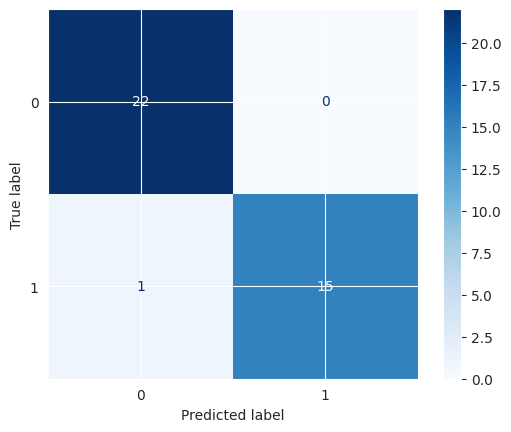

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.94      0.97        16

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38

Average Accuracy with CV: 0.9193103448275863


In [37]:
filepath=r'../data/raw/bone-marrow.csv'

model = BoneMarrowModel(filepath)
model.load_data()
model.preprocess_data()
model.train_model()
model.evaluate_model()
model.cross_validate_model()